# [WIP] Model 11: Cultural group selection

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model11.html

## Note
- The emergence and maintenance of cooperation requires explanation.
- The conflict between the individual and group level:
    - within groups, free-riding individuals do better than cooperating individuals,
    - yet groups of cooperators collectively do better than groups of free-riders.
- Solutions to the free-rider problem include kin selection and reciprocity.
- Yet each of these has limitations with respect to human cooperation:
    - kin selection cannot explain cooperation towards non-kin, which humans do frequently;
    - reciprocity cannot explain cooperation between strangers and breaks down in large groups, which are again common features of human societies;
    - and punishment is itself costly, leading to a second-order free-rider problem where non-punishing cooperators outcompete punishing cooperators.
- Consequently, some cultural evolution researchers have suggested that human cooperation can arise via __cultural group selection__ (Richerson et al. 2016).
    - This occurs when more-cooperative groups outcompete less-cooperative groups in between-group competition.
    - Genetic group selection does not seem to work:
        - between-group genetic variation is easily broken down by migration,
        - and individual-level natural selection is too strong.
    - Cultural evolution, however, provides better conditions:
        - rapid cultural selection (Model 3) can generate differences between groups,
        - and processes such as conformity (Model 5) or polarisation (Model 10) can maintain between-group cultural variation despite frequent migration (see Model 7).
    - Between-group competition can occur via direct conquest, e.g. warfare, where more-cooperative societies full of self-sacrificial fighters out-compete less-cooperative societies full of deserting back-stabbers.
    - Or it can occur indirectly, such as where more-cooperative societies, e.g. ones with better social welfare systems, attract more migrants than less-cooperative societies.
    - Success in between-group competition does not necessarily require the death of the defeated group’s members.
    - Instead, defeated group members can disband and join the winning group.
- This model ([Boyd, Gintis, Bowles & Richerson (2003)](https://doi.org/10.1073/pnas.0630443100)) features
    - costly (i.e. altruistic) punishment within groups,
    - mixing / migration between groups,
    - payoff-biased social learning and
    - between-group selection.

In [1]:
using Statistics
using StatsBase
using LinearAlgebra
using Plots
using Plots.PlotMeasures

using Test: @testset, @test

## Stage 0: Setup agents

- Make traits and payoff table.
- Each agent can be C (cooperator), D (defector) or P (punisher). C cooperates, D defects, and P cooperates and punishes.
- `n_group`: Group count. Each column is a group.
- `n_agent`: Agent count per group

In [2]:
function make_traits(n_agent::Int, n_group::Int)::Matrix{String}
#     traits = [rand(["C", "D", "P"]) for _ in 1:n_group*n_agent]
#     reshape(traits, (n_agent, n_group))
    traits = fill("D", (n_agent, n_group))
    traits[:, 1] = fill("P", n_agent)
    traits
end

function make_payoffs(n_agent::Int, n_group::Int)::Matrix{Float64}
    fill(1.0, (n_agent, n_group))
end;

In [3]:
@testset "make_traits" begin
    traits = make_traits(4, 3)
    @test traits[:, 1] == ["P", "P", "P", "P"]
    @test traits[:, 2] == ["D", "D", "D", "D"]
    @test traits[:, 3] == ["D", "D", "D", "D"]
end

@testset "make_payoffs" begin
    payoffs = make_payoffs(4, 3)
    @test size(payoffs) == (4, 3)
    @test payoffs == fill(1.0, (4, 3))
end;

Test Summary: | Pass  Total  Time
make_traits   |    3      3  0.2s
Test Summary: | Pass  Total  Time
make_payoffs  |    2      2  0.0s


## Stage 1: Cooperation

- Update payoffs of C and P.
- Cooperators and punishers cooperate with probability $1 − e$ and defect with probability $e$. The parameter $e$ represents errors.
- Cooperation reduces the cooperating agent’s payoff by $c$. This makes cooperation costly.
- Defectors always defect and pay no cost.

In [4]:
function cooperation!(payoffs::Matrix{Float64}, traits::Matrix{String}, c::Float64, e::Float64)::Matrix{Float64}
    n_agent, n_group = size(payoffs)
    contributors = (rand(n_agent, n_group) .> e) .&& (traits .== "C" .|| traits .== "P")
    payoffs .-= contributors .* c
end;

In [27]:
@testset "cooperation!" begin
    traits = ["C" "P" "D"; "C" "P" "D"; "C" "P" "D"; "C" "P" "D"]
    @test cooperation!(make_payoffs(4, 3), traits, 0.2, 0.0) == [0.8 0.8 1.0; 0.8 0.8 1.0; 0.8 0.8 1.0; 0.8 0.8 1.0]

    traits = fill("C", (50, 20))
    @test mean(cooperation!(make_payoffs(50, 20), traits, 0.2, 0.5)) ≈ 0.9 atol = 10^-2

    traits = ["C" "P" "D"; "C" "P" "D"; "C" "P" "D"; "C" "P" "D"]
    @test cooperation!(make_payoffs(4, 3), traits, 0.2, 1.0) == [1.0 1.0 1.0; 1.0 1.0 1.0; 1.0 1.0 1.0; 1.0 1.0 1.0]
end;

Test Summary: | Pass  Total  Time
cooperation!  |    3      3  0.0s


## Stage 2: Punishment

- Update payoffs of D and P.
- Punishers (Ps) punish every agent in their group who defected in the first stage.
- Punishment reduces each defector’s payoff by $p/n$ at a cost of $k/n$ to the punisher.
- The parameter $k$ makes punishment costly.
- The more punishers there are in a group, the more punishment defectors receive.
- The more defectors there are, the more costly punishment is to the punisher.

In [6]:
function punishment!(payoffs::Matrix{Float64}, traits::Matrix{String}, p::Float64, k::Float64)::Matrix{Float64}
    n_agent, n_group = size(payoffs)
    _k = k / n_agent
    _p = p / n_agent

    for group in 1:n_group
        _traits = traits[:, group]
        p_count = count(t -> t == "P", _traits)
        d_count = count(t -> t == "D", _traits)
        
        payoffs[:, group] .-= (_traits .== "P") .* (d_count * _k)
        payoffs[:, group] .-= (_traits .== "D") .* (p_count * _p)
    end

    payoffs
end;

In [7]:
@testset "punishment!" begin
    # Test condition
    n_group = 7
    n_agent = 5
    p = 0.7  # cost to defector
    k = 0.2  # cost to punisher
    traits = make_traits(n_agent, n_group)
    traits[:, 1] = ["C", "D", "D", "D", "D"]
    traits[:, 2] = ["P", "D", "D", "D", "D"]
    traits[:, 3] = ["C", "P", "D", "D", "D"]
    traits[:, 4] = ["C", "C", "D", "D", "D"]
    traits[:, 5] = ["P", "P", "D", "D", "D"]
    traits[:, 6] = ["C", "C", "P", "P", "D"]
    payoffs = make_payoffs(n_agent, n_group)

    # Target
    punishment!(payoffs, traits, p, k)

    # Expected results
    @test payoffs[:, 1] == [1.0, 1.0, 1.0, 1.0, 1.0]

    @test 1.0 - 4k / 5 == 0.84
    @test 1.0 - 1p / 5 == 0.86
    @test payoffs[:, 2] == [0.84, 0.86, 0.86, 0.86, 0.86]

    @test 1.0 - 3k / 5 == 0.88
    @test 1.0 - 1p / 5 == 0.86
    @test payoffs[:, 3] == [1.0, 0.88, 0.86, 0.86, 0.86]

    @test payoffs[:, 4] == [1.0, 1.0, 1.0, 1.0, 1.0]

    @test 1.0 - 3k / 5 == 0.88
    @test 1.0 - 2p / 5 == 0.72
    @test payoffs[:, 5] == [0.88, 0.88, 0.72, 0.72, 0.72]

    @test 1.0 - 1k / 5 == 0.96
    @test 1.0 - 2p / 5 == 0.72
    @test payoffs[:, 6] == [1.0, 1.0, 0.96, 0.96, 0.72]

    @test payoffs[:, 7] == [1.0, 1.0, 1.0, 1.0, 1.0]
end;

Test Summary: | Pass  Total  Time
punishment!   |   15     15  0.1s


## Stage 3: Payoff-biased social learning with inter-group mixing

- Update traits.
- $m$ controls the rate of between-group mixing.
    - With probability $1 − m$, agents interact with a random member of their own group.
    - With probability  $m$, agents interact with a random member of another group.
- Once a demonstrator is chosen, the focal individual then copies the behaviour (C, D or P) of the demonstrator with probability $\frac{\pi_{dem}}{\pi_{dem} + \pi_{focal}}$ where $\pi$ means payoff.
    - High-payoff behaviours are therefore more likely to be copied.

In [8]:
function get_demonstrator(focal_group::Int, focal_agent::Int, n_group::Int, n_agent::Int, m::Float64)::Tuple{Int, Int}
    if rand() > m
        # With probability 1 − m, agents interact with a random member of their own group.
        demonstrator_group = focal_group
        demonstrator_agent = rand([i for i in 1:n_agent if i != focal_agent])
    else
        # With probability m, agents interact with a random member of another group.
        demonstrator_group = rand([i for i in 1:n_group if i != focal_group])
        demonstrator_agent = rand(1:n_agent)
    end

    (demonstrator_group, demonstrator_agent)
end

function pairwise_fermi(focal_payoff::Float64, demonstrator_payoff::Float64, κ::Float64 = 1.0)::Float64
    1 / (1 + exp((focal_payoff - demonstrator_payoff) / κ))
end

function payoff_biased_social_learning!(traits::Matrix{String}, payoffs::Matrix{Float64}, m::Float64)::Matrix{String}
    n_agent, n_group = size(payoffs)
    previous_traits = copy(traits)

    for focal_group in 1:n_group
        for focal_agent in 1:n_agent
            demonstrator_group, demonstrator_agent = get_demonstrator(focal_group, focal_agent, n_group, n_agent, m)
            focal_payoff = payoffs[focal_agent, focal_group]
            demonstrator_payoff = payoffs[demonstrator_agent, demonstrator_group]
            # prob_to_copy = demonstrator_payoff / (focal_payoff + demonstrator_payoff)
            prob_to_copy = pairwise_fermi(focal_payoff, demonstrator_payoff)

            if prob_to_copy > rand()
                traits[focal_agent, focal_group] = previous_traits[demonstrator_agent, demonstrator_group]
            end
        end
    end

    traits
end;

In [9]:
@testset "get_demonstrator" begin
    # Test condition:
    focal_group = 1
    focal_agent = 1
    n_group = 5
    n_agent = 10
    m = 0.2  # With probability m, agents interact with a random member of another group.
    trial = 10^7

    # Target:
    demonstrators = [get_demonstrator(focal_group, focal_agent, n_group, n_agent, m) for _ in 1:trial]

    # Expected results:
    # 1 - m の確率で同じグループが選ばれる
    @test count(d -> d[1] == 1, demonstrators) / trial ≈ (1 - m) atol = 10^-2
    # m の確率で別のグループが選ばれる
    @test count(d -> d[1] != 1, demonstrators) / trial ≈ m atol = 10^-2
    @test count(d -> d[1] == 5, demonstrators) / trial ≈ m / (n_group - 1) atol = 10^-2
    
    # 同じグループのエージェントがdemonstratorになった場合は、2〜10のエージェントがランダムに選ばれる
    @test mean([a for (g, a) in demonstrators if g == focal_group]) ≈ mean([2, 3, 4, 5, 6, 7, 8, 9, 10]) atol = 10^-2
    # 別のグループのエージェントがdemonstratorになった場合は、1〜10のエージェントがランダムに選ばれる
    @test mean([a for (g, a) in demonstrators if g != focal_group]) ≈ mean([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) atol = 10^-2
end;

Test Summary:    | Pass  Total  Time
get_demonstrator |    5      5  2.1s


In [10]:
@testset "pairwise_fermi" begin
    @test pairwise_fermi(-1.0, 10.0) == 0.999983298578152
    @test pairwise_fermi(1.0, 10.0) == 0.9998766054240137
    @test pairwise_fermi(1.0, 1.0) == 0.5
    @test pairwise_fermi(10.0, 10.0) == 0.5
    @test pairwise_fermi(10.0, 1.0) == 0.00012339457598623172
    @test pairwise_fermi(10.0, -1.0) ≈ 0.00001670142184809518

    @test pairwise_fermi(-1.0, 10.0, 0.1) == 1.0
    @test pairwise_fermi(-1.0, 10.0, 0.01) == 1.0
    @test pairwise_fermi(1.0, 1.0, 0.1) == 0.5
    @test pairwise_fermi(10.0, 10.0, 0.1) == 0.5
    @test pairwise_fermi(10.0, -1.0, 0.1) ≈ 0.0 atol = 10^-5
end;

Test Summary:  | Pass  Total  Time
pairwise_fermi |   11     11  0.0s


## Stage 4: Group selection

- Groups are paired at random and with probability $\epsilon$ enter into a contest.
- the probability that group 1 defeats group 2 in a pair is $\frac{1}{2} + \frac{d_2 - d_1}{2}$,
    - where $d_1$ is the proportion of defectors in group 1 of a pair and
    - $d_2$ is the proportion of defectors in group 2 of the pair.

In [11]:
function group_selection!(traits::Matrix{String}, e::Float64, ϵ::Float64)::Matrix{String}
    n_agent, n_group = size(traits)
    
    # Matrix of randomly selected pairs of groups
    contests = sample(1:n_group, (n_group ÷ 2, 2), replace = false)
    # Keep contests with prob ϵ
    contests = contests[rand(n_group ÷ 2) .< ϵ, :]
    
    # Defectors (Ds and Ps/Cs with probability e)
    defectors = (traits .== "D") .|| (
        (rand(n_agent, n_group) .< e) .&& (traits .== "C" .|| traits .== "P")
    )

    for group in eachrow(contests)
        # probability that group 1 defeats group 2
        d1 = sum(defectors[:, group[1]]) / n_agent
        d2 = sum(defectors[:, group[2]]) / n_agent
        d = 0.5 + (d2 - d1) / 2

        if rand() < d
            # group 1 wins
            traits[:, group[2]] .= traits[:, group[1]]
        else
            # group 2 wins
            traits[:, group[1]] .= traits[:, group[2]]
        end
    end

    traits
end;

In [12]:
n_group = 10
ϵ = 0.0
contests = sample(1:n_group, (n_group ÷ 2, 2), replace = false)
contests = contests[rand(n_group ÷ 2) .< ϵ, :]

0×2 Matrix{Int64}

## Stage 5: Mutation

In [13]:
function mutate(trait::String)::String
    trait == "C" && return rand(["P", "D"])
    trait == "P" && return rand(["C", "D"])
    trait == "D" && return rand(["C", "P"])
end

function mutation!(traits::Matrix{String}, μ::Float64)::Matrix{String}
    traits .= [μ > rand() ? mutate(t) : t for t in traits]
end;

In [14]:
@testset "mutation!" begin
    prev_traits = rand(["C", "P", "D"], 7, 11)
    post_traits = mutation!(copy(prev_traits), 1.0)
    @test [prev != post for (prev, post) in zip(prev_traits, post_traits)] == fill(true, (7, 11))

    prev_traits = rand(["C", "P", "D"], 7, 11)
    post_traits = mutation!(copy(prev_traits), 0.0)
    @test [prev == post for (prev, post) in zip(prev_traits, post_traits)] == fill(true, (7, 11))
end;

Test Summary: | Pass  Total  Time
mutation!     |    2      2  0.1s


## Run all

In [15]:
function run_all(;
        n_group::Int = 128,  # group count
        n_agent::Int = 4,    # agent count in a group
        t_max::Int = 4000,   # time steps
        e::Float64 = 0.02,   # error rate
        c::Float64 = 0.2,    # cost of cooperation
        m::Float64 = 0.01,   # rate of between-group mixing
        p::Float64 = 0.8,    # cost to defector
        k::Float64 = 0.2,    # cost to punisher
        μ::Float64 = 0.01,   # mutation rate
        ϵ::Float64 = 0.015,   # frequency of conflict
        title::String = ""
    )::Matrix{Float64}
    
    traits = make_traits(n_agent, n_group)
    payoffs = make_payoffs(n_agent, n_group)
    @assert size(payoffs) == size(traits) == (n_agent, n_group)

    outputs = fill(0.0, (t_max, 2))

    for t = 1:t_max
        cooperation!(payoffs, traits, c, e)
        punishment!(payoffs, traits, p, k)
        payoff_biased_social_learning!(traits, payoffs, m)
        group_selection!(traits, e, ϵ)
        mutation!(traits, μ)

        # save cooperator rate
        outputs[t, 1] = count(t -> t == "C", traits) / (n_group * n_agent)
        outputs[t, 2] = count(t -> t in ["C", "P"], traits) / (n_group * n_agent)
    end
    
    # Plot
    if title != ""
        p = plot(
            ylims = (-0.01, 1.01),
            title = title,
            xlabel = "generation",
            ylabel = "frequency of cooperators"
        )
        plot!(outputs[:, 2], lc = :blue, label = "Cooperator and Punisher")
        plot!(outputs[:, 1], lc = :skyblue, label = "Cooperator")

        cooperator_rate1 = mean(outputs[Int(round(t_max * 0.8)):t_max, 1])
        cooperator_rate2 = mean(outputs[Int(round(t_max * 0.8)):t_max, 2])
        println("Cooperator and Punisher: $cooperator_rate2")
        println("Cooperator:\t\t $cooperator_rate1")
        
        display(p)
    end
    
    return outputs
end;

Cooperator and Punisher: 0.8046996917915106
Cooperator:		 0.3566391619850187


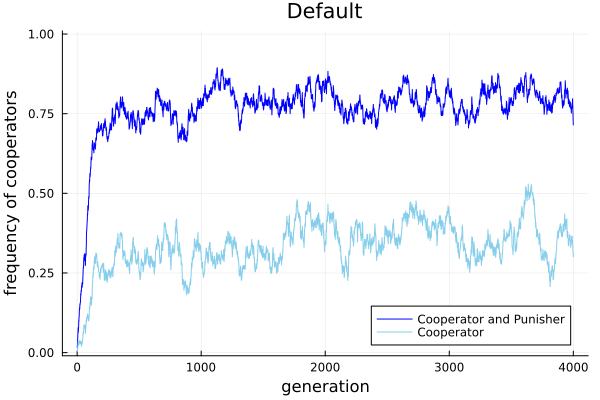

In [16]:
run_all(title = "Default");

Cooperator and Punisher: 0.7541930618952871
Cooperator:		 0.2980131037375156


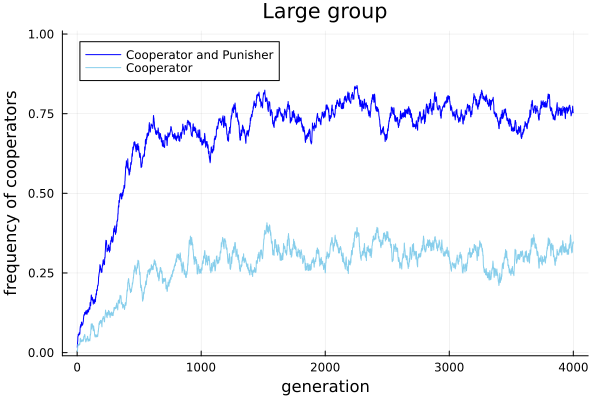

In [17]:
run_all(n_agent = 32, title = "Large group");

1グループ当たりのエージェント数を増やすと協力率はやや下がる。

グループが大きくなると協力が難しくなるのは、よく知られた結論である。

`p` (cost to defector) と `k` (cost to punisher) を`0`にすることで、モデルから罰の要素を取り除くと、協力は成立しなくなる。

Cooperator and Punisher: 0.5111621947175405
Cooperator:		 0.25610382041978774


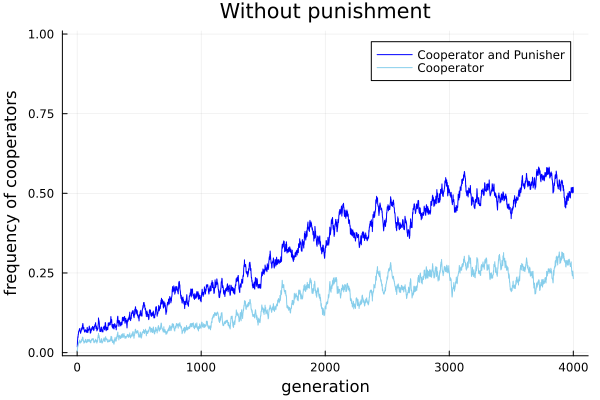

In [18]:
run_all(n_agent = 32, p = 0.0, k = 0.0, title = "Without punishment");

Cooperator and Punisher: 0.6220672645521224
Cooperator:		 0.27973059798299


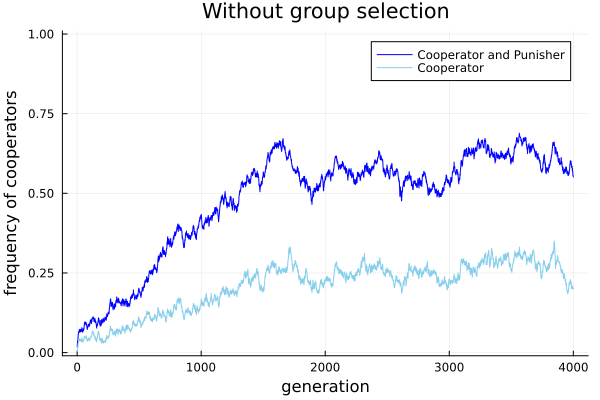

In [19]:
run_all(n_agent = 32, ϵ = 0.0, title = "Without group selection");

Cooperator and Punisher: 0.7592395491963171
Cooperator:		 0.3285895072565543


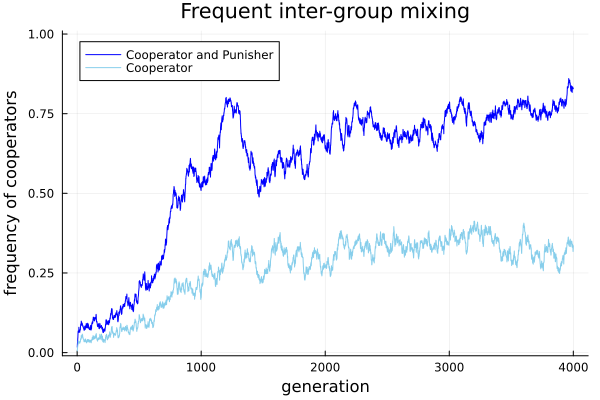

In [20]:
run_all(n_agent = 32, m = 0.05, title = "Frequent inter-group mixing");

## Frequency of cooperation across a range of group sizes

In [21]:
t_max = 5000
n_agent_vec = [4, 8, 16, 32, 64]
ϵ_vec = [0.0075, 0.015, 0.03]
output = fill(0.0, length(n_agent_vec), length(ϵ_vec))

for i in 1:length(ϵ_vec)
    for j = 1:length(n_agent_vec)
        println("ϵ: $(ϵ_vec[i]), n_agent: $(n_agent_vec[j])")
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], ϵ = ϵ_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

ϵ: 0.0075, n_agent: 4
ϵ: 0.0075, n_agent: 8
ϵ: 0.0075, n_agent: 16
ϵ: 0.0075, n_agent: 32
ϵ: 0.0075, n_agent: 64
ϵ: 0.015, n_agent: 4
ϵ: 0.015, n_agent: 8
ϵ: 0.015, n_agent: 16
ϵ: 0.015, n_agent: 32
ϵ: 0.015, n_agent: 64
ϵ: 0.03, n_agent: 4
ϵ: 0.03, n_agent: 8
ϵ: 0.03, n_agent: 16
ϵ: 0.03, n_agent: 32
ϵ: 0.03, n_agent: 64


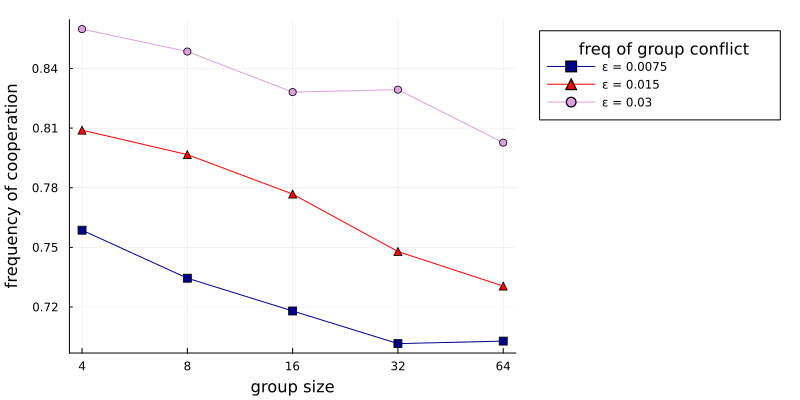

In [22]:
p = plot(
    legend=:outertopright,
    legendtitle="freq of group conflict",
    xlabel= "group size",
    ylabel="frequency of cooperation",
    xticks=(1:length(n_agent_vec), n_agent_vec),
    size=(800, 400),
    margin=3mm
)
for (i, col) in enumerate([:darkblue, :red, :plum])
    plot!(
        1:length(n_agent_vec),
        output[:, i], 
        markershape=[:square, :utriangle, :circle][i],
        markercolor=col,
        linecolor=col,
        label="ε = $(ϵ_vec[i])"
    )
end
p